In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from ewt import ewt2d
from ewt.utilities import ewt_params
from scipy.signal import convolve2d
from math import ceil,floor

# Supervised Texture Classification 3: Empirical Curvelets
In previous notebooks, we explored fully connected network for supervised texture classification. we now explore the use of empirical curvelets as a preprocessing step to feed into the network. The idea behind this is from Huang et Al.'s paper [1], which is to build a filter bank based on the empirical curvelet detection of each given texture. The gains in the paper show this as an interesting direction to take. However, I am curious about the work in practice, hence working on it myself.

We begin by loading in the training images.

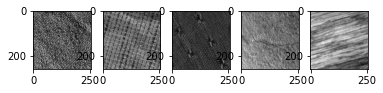

In [2]:
fol = "data/000/"
Text1 = plt.imread(fol+'train_01.ras')
Text2 = plt.imread(fol+'train_02.ras')
Text3 = plt.imread(fol+'train_03.ras')
Text4 = plt.imread(fol+'train_04.ras')
Text5 = plt.imread(fol+'train_05.ras')

plt.figure()
plt.subplot(151)
plt.imshow(Text1,cmap = 'gray')
plt.subplot(152)
plt.imshow(Text2,cmap = 'gray')
plt.subplot(153)
plt.imshow(Text3,cmap = 'gray')
plt.subplot(154)
plt.imshow(Text4,cmap = 'gray')
plt.subplot(155)
plt.imshow(Text5,cmap = 'gray')

We will start with the first texture and apply the Curvelet-1 EWT. 

Before using empirical curvelets, we make sure that the input image has one channel of type double.

In [3]:
print(Text1.shape)
print(Text1[0,0])

(256, 256)
101


In [4]:
Text1 = Text1/255.0

As a reminder, empirical wavelet transforms are multi-resolution analysis tools that construct a tight frame filter bank based on a partitioning of the Fourier domain. The empirical curvelet detects a set of boundaries based on the pseudo-polar EWT and as such, partitions the Fourier domain with polar wedges. The first option detects angles and scales independently. Scales are normalized on the range $[0,\pi]$ and angles are $[-3\pi/4,\pi/4]$.

In [5]:
#Get default ewt parameters, set curvelet option to 1, set log to 1
params = ewt_params();
params.option = 1;
params.log = 1
[ewtc1,mfb1,Bs1,Bw1] = ewt2d.ewt2dCurvelet(Text1,params)
print(f'Number of scales for text 1: {len(Bs1)} \n Number of angles per scale: {len(Bw1)}\n')

Number of scales for text 1: 2 
 Number of angles per scale: 3



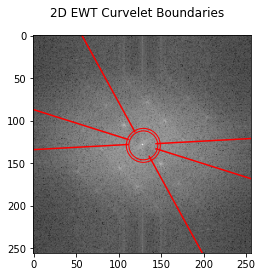

C:\Users\Basile\Documents\Research\Neural_Network\ewt\utilities.py:438: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(np.sqrt(m)),np.ceil(np.sqrt(m)),j+1)


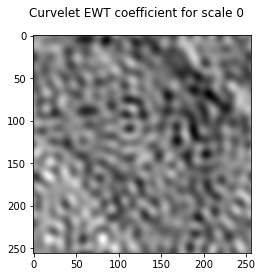

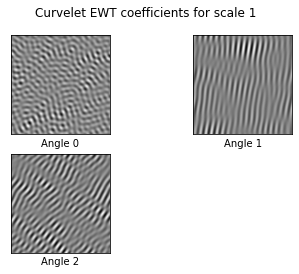

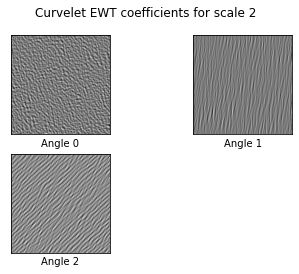

In [6]:
ewt2d.show2DCurveletBoundaries(Text1,1,Bs1,Bw1)
ewt2d.showEWT2DCoefficients(ewtc1,ewt_type='curvelet')

We see that it has detected 3 scales and 3 angular boundaries, leading to 7 coefficients. We now do this for the remaining textures. 

In [7]:
_,_,Bs2,Bw2 = ewt2d.ewt2dCurvelet(Text2,params)
print(f'Number of scales for text 2: {len(Bs2)} \n Number of angles per scale (excluding approx): {len(Bw2)}\n')
_,_,Bs3,Bw3 = ewt2d.ewt2dCurvelet(Text3,params)
print(f'Number of scales for text 3: {len(Bs3)} \n Number of angles per scale (excluding approx): {len(Bw3)}\n')
_,_,Bs4,Bw4 = ewt2d.ewt2dCurvelet(Text4,params)
print(f'Number of scales for text 4: {len(Bs4)} \n Number of angles per scale (excluding approx): {len(Bw4)}\n')
_,_,Bs5,Bw5 = ewt2d.ewt2dCurvelet(Text5,params)
print(f'Number of scales for text 5: {len(Bs5)} \n Number of angles per scale (excluding approx): {len(Bw5)}\n')

Number of scales for text 2: 5 
 Number of angles per scale (excluding approx): 3

Number of scales for text 3: 6 
 Number of angles per scale (excluding approx): 4

Number of scales for text 4: 3 
 Number of angles per scale (excluding approx): 3

Number of scales for text 5: 2 
 Number of angles per scale (excluding approx): 3



So, in conclusion, we have 5 sets of boundaries, shown below

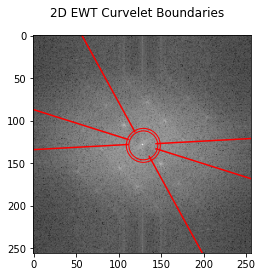

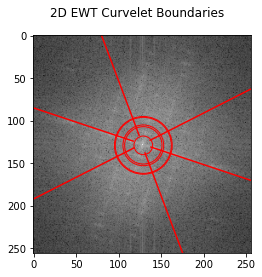

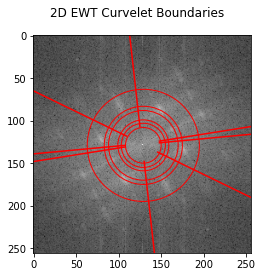

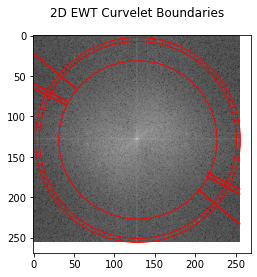

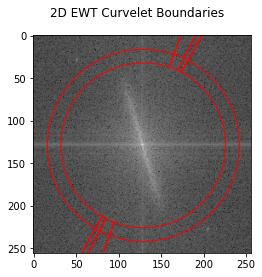

In [8]:
ewt2d.show2DCurveletBoundaries(Text1,1,Bs1,Bw1)
ewt2d.show2DCurveletBoundaries(Text2,1,Bs2,Bw2)
ewt2d.show2DCurveletBoundaries(Text3,1,Bs3,Bw3)
ewt2d.show2DCurveletBoundaries(Text4,1,Bs4,Bw4)
ewt2d.show2DCurveletBoundaries(Text5,1,Bs5,Bw5)

Once we have these 10 sets of boundaries (5 for scales and 5 for angles), the idea is to merge the sets.

In [9]:
Bs_merge = np.concatenate((Bs1,Bs2,Bs3,Bs4,Bs5))
Bs_merge = np.sort(Bs_merge)
print(f'{len(Bs_merge)} Scales')
print(Bs_merge)
Bw_merge = np.concatenate((Bw1,Bw2,Bw3,Bw4,Bw5))
Bw_merge = np.sort(Bw_merge)
print(f'{len(Bw_merge)} Angles')
print(Bw_merge)


18 Scales
[0.26998062 0.41724277 0.49087385 0.51541754 0.53996124 0.58904862
 0.63813601 0.73631078 0.80994186 0.83448555 1.0062914  1.12900986
 1.61988371 2.38073818 2.40528188 2.77343726 2.9943305  3.11704896]
16 Angles
[-2.07394203 -1.92667987 -1.68124294 -1.22718463 -1.11673801 -1.06765063
 -0.46633016 -0.159534   -0.08590292 -0.04908739  0.30679616  0.319068
  0.45405831  0.45405831  0.49087385  0.68722339]


With this, we are nearly ready to make a filter bank. However, We do not want to keep boundaries that are too close together, as that is generally bad practice. As such, we pick a threshold and remove boundaries that are too close together. By default, we remove the higher boundary. We use the same values as [1], setting the scale threshold to be $T_s = 0.3$ and the angular threshold to be $T_\theta = 0.14$.

In [10]:
Ts = 0.3
while Bs_merge[0] < Ts: #Check smallest scale
    Bs_merge = np.delete(Bs_merge,0)
i = 1
while i < len(Bs_merge): #Check between scales
    if np.abs(Bs_merge[i] - Bs_merge[i-1]) < Ts:
        Bs_merge = np.delete(Bs_merge,i)
    else:
        i += 1
while np.pi - Bs_merge[-1] < Ts: #Check last scale
    Bs_merge = np.delete(Bs_merge,-1)
    
Tw = 0.14
while i < len(Bw_merge): #Check between angles
    if np.abs(Bw_merge[i] - Bw_merge[i-1]) < Tw:
        Bw_merge = np.delete(Bw_merge,i)
    else:
        i += 1
while np.abs(Bw_merge[0] - Bw_merge[-1]) < Tw: #check between first and last angle
    Bw_merge = np.delete(Bw_merge,-1)
print(f'{len(Bs_merge)} Scales')
print(Bs_merge)
print(f'{len(Bw_merge)} Angles')
print(Bw_merge)

6 Scales
[0.41724277 0.73631078 1.12900986 1.61988371 2.38073818 2.77343726]
11 Angles
[-2.07394203 -1.92667987 -1.68124294 -1.22718463 -1.11673801 -1.06765063
 -0.46633016 -0.159534    0.30679616  0.45405831  0.68722339]


Therefore, with 6 scales and 11 angles, we should have 67 filters! Which is admittedly a lot. We could reduce this by messing with the threshold values. For now, however, we move forward. The goal now is to preprocess our data before feeding it into the network. The preprocessing is the following 
1. Filter the input (using fft and pointwise multiplication as our filters are defined in Fourier transform, then returning to curvelet domain with ifft)
2. Use energy aggregate methods (L^2 on a 19x19 window centered at pixel)
3. ZCA Whiten

In [11]:
mfb1 = ewt2d.ewt2d_curveletFilterbank(Bs_merge,Bw_merge,256,256,1)
num_filt = 1 + (len(mfb1)-1)*len(mfb1[1])
filt = np.zeros([256,256,num_filt])
filt[:,:,0] = mfb1[0][0]
for i in range(1,len(mfb1)):
    for j in range(0,len(mfb1[i])):
        filt[:,:,1+(i-1)*len(mfb1[i])+j] = mfb1[i][j]

print(filt.shape)
del mfb1

(256, 256, 67)


In [12]:
def FourierFilters(x,filt):
    filt_num = len(filt)
    y = np.copy(filt)
    for i in range(0,filt.shape[-1]):
            y[:,:,i] = np.real(np.fft.ifft2(np.fft.fft2(x)*filt[:,:,i]))
    return y
def L2window(x,n):
    x = x*x
    L2filt = np.ones([n,n])
    y = convolve2d(x,L2filt,'same')
    return y

def zca_whiten(x):
    y = x - np.mean(x)

    y = y.reshape(x.shape[0]*x.shape[1],x.shape[2])
    # Calculate principal components
    sigma = np.dot(y.T, y) / y.shape[0]
    
    u, s, _ = np.linalg.svd(sigma)
    principal_components = np.dot(np.dot(u, np.diag(1.0 / np.sqrt(s + 10e-7))), u.T)

    # Apply ZCA whitening
    zca = np.dot(y, principal_components)
    zca = zca.reshape(x.shape[0],x.shape[1],x.shape[2])
    return zca
def zero_mean(x):
    y = (x - np.min(x))/(np.max(x) - np.min(x))
    return y - np.mean(y)


100.52108260263992
8.694009566299147


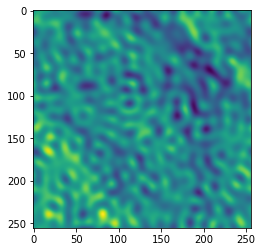

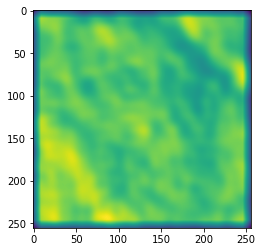

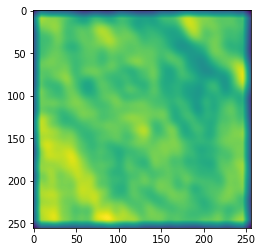

In [13]:
ex = FourierFilters(Text1,filt)
plt.figure()
plt.imshow(ex[:,:,0])
for i in range(0,filt.shape[-1]):
    ex[:,:,i] = L2window(ex[:,:,i],19)
plt.figure()
plt.imshow(ex[:,:,0])
print(np.max(ex))

ex = zca_whiten(ex)
plt.figure()
plt.imshow(ex[:,:,0])
print(np.max(ex))
del ex

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

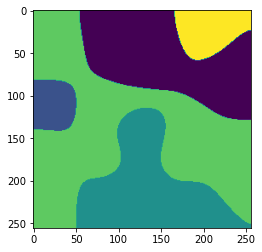

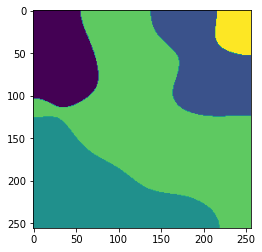

In [14]:
num_train = 600
train = np.zeros([num_train,256,256,filt.shape[-1]],'float32')
trainlab = np.zeros([num_train,256,256,1],'int8')
for i in range(0,num_train):
    train[i,:,:,0] = plt.imread('data/000/data'+str(i)+'.png')[:,:,0]
    train[i,:,:,0] -= np.min(train[i,:,:,0])
    train[i,:,:,0] /= np.max(train[i,:,:,0])
    #Perform ewt and post-processing
    train[i,:,:,:] = FourierFilters(train[i,:,:,0],filt)
    for j in range(0,filt.shape[-1]):
        train[i,:,:,j] = L2window(train[i,:,:,j],19)
    train[i,:,:,:] = zca_whiten(train[i,:,:,:])
    temp1 = plt.imread('data/GT/GT'+str(i)+'.png')[:,:,0]
    temp3 = np.copy(temp1)
    temp2 = np.unique(temp1)
    for k in range(0,5):
        temp3[temp1 == temp2[k]] = k
    trainlab[i,:,:,0] = temp3.astype(int)
    print(i)
valid = np.zeros([25,256,256,filt.shape[-1]],'float32')
validlab = np.zeros([25,256,256,1],'int8')
for i in range(600,625):
    valid[i-600,:,:,0] = plt.imread('data/000/data'+str(i)+'.png')[:,:,0]
    valid[i-600,:,:,0] -= np.min(valid[i-600,:,:,0])
    valid[i-600,:,:,0] /= np.max(valid[i-600,:,:,0])
    #Perform ewt and post-processing
    valid[i-600,:,:,:] = FourierFilters(valid[i-600,:,:,0],filt)
    for j in range(0,filt.shape[-1]):
        valid[i-600,:,:,j] = L2window(valid[i-600,:,:,j],19)
    valid[i-600,:,:,:] = zca_whiten(valid[i-600,:,:,:])
    temp1 = plt.imread('data/GT/GT'+str(i)+'.png')[:,:,0]
    temp3 = np.copy(temp1)
    temp2 = np.unique(temp1)
    for k in range(0,5):
        temp3[temp1 == temp2[k]] = k 
    validlab[i-600,:,:,0] = temp3.astype(int)
    print(i)
plt.figure()
plt.imshow(trainlab[0,:,:,0])
plt.figure()
plt.imshow(validlab[0,:,:,0])

Lets look at our training and validation datasets to confirm that they were constructed correctly.

<Figure size 432x288 with 0 Axes>

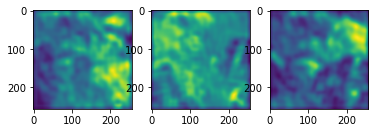

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure()
for i in range(0,3):
    plt.subplot(131+i)
    plt.imshow(train[i,:,:,0])
plt.figure()

#for i in range(0,3):
#    plt.subplot(131+i)
#    plt.imshow(valid[i,:,:,0])

With this, we can begin training our model. The model is the same as the FCNT used before. Some layer sizes are different to account for the memory constraints.

In [16]:
layer_number = [20,20,20,40,40,40,5]
layer_size = [5,5,3,3,3,3,3]
print(sum(layer_number))
input_ = keras.layers.Input(shape=[256,256, train.shape[-1]])

hidden1 = keras.layers.Conv2D(layer_number[0],layer_size[0],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(input_)
maxPool1 = keras.layers.MaxPool2D(2)(hidden1)

hidden2 = keras.layers.Conv2D(layer_number[1],layer_size[1],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool1)
maxPool2 = keras.layers.MaxPool2D(2)(hidden2)

hidden3 = keras.layers.Conv2D(layer_number[2],layer_size[2],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool2)
maxPool3 = keras.layers.MaxPool2D(2)(hidden3)

hidden4 = keras.layers.Conv2D(layer_number[3],layer_size[3],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool3)
maxPool4 = keras.layers.MaxPool2D(2)(hidden4)

hidden5 = keras.layers.Conv2D(layer_number[4],layer_size[4],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool4)
hidden6 = keras.layers.Conv2D(layer_number[5],layer_size[5],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(hidden5)

#upsample
maxPool2Up = keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(maxPool2)
maxPool3Up =  keras.layers.UpSampling2D(size=(4, 4), interpolation='nearest')(maxPool3)
hidden6Up =  keras.layers.UpSampling2D(size=(8, 8), interpolation='nearest')(hidden6)

#combine
combined = keras.layers.Concatenate()([maxPool1,maxPool2Up,maxPool3Up,hidden6Up])
#upsample
combinedUp = keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(combined)
output_ = keras.layers.Conv2D(5,1,padding = 'same',activation = 'softmax')(combinedUp)
    
model = keras.Model(inputs = input_, outputs = output_)

185


When fitting our model, we noticed that the validation accuracy started dropping after 20 epochs. As such, we set this as our stopping point.

In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train, trainlab, 
                    epochs=20,
                    validation_data = [valid,validlab]
                   )

Train on 600 samples, validate on 25 samples
Epoch 1/20
600/600 [==============================] - 762s 1s/sample - loss: 1.3440 - accuracy: 0.5907 - val_loss: 1.1353 - val_accuracy: 0.7864
Epoch 2/20
600/600 [==============================] - 515s 858ms/sample - loss: 1.1058 - accuracy: 0.8140 - val_loss: 1.0660 - val_accuracy: 0.8539
Epoch 3/20
600/600 [==============================] - 639s 1s/sample - loss: 1.0629 - accuracy: 0.8572 - val_loss: 1.0475 - val_accuracy: 0.8728
Epoch 4/20
600/600 [==============================] - 620s 1s/sample - loss: 1.0421 - accuracy: 0.8782 - val_loss: 1.0278 - val_accuracy: 0.8927
Epoch 5/20
600/600 [==============================] - 568s 947ms/sample - loss: 1.0295 - accuracy: 0.8909 - val_loss: 1.0162 - val_accuracy: 0.9043
Epoch 6/20
600/600 [==============================] - 730s 1s/sample - loss: 1.0172 - accuracy: 0.9033 - val_loss: 1.0116 - val_accuracy: 0.9085
Epoch 7/20
600/600 [==============================] - 593s 988ms/sample - loss:

In [18]:
del train
del trainlab
del valid
del validlab

test = np.zeros([75,256,256,67],'float32')
testlab = np.zeros([75,256,256,1],'int8')
for i in range(925,1000):
    test[i-925,:,:,0] = plt.imread('data/000/data'+str(i)+'.png')[:,:,0]
    test[i-925,:,:,0] -= np.min(test[i-925,:,:,0])
    test[i-925,:,:,0] /= np.max(test[i-925,:,:,0])
    #Perform ewt and post-processing
    test[i-925,:,:,:] = FourierFilters(test[i-925,:,:,0],filt)
    for j in range(0,filt.shape[-1]):
        test[i-925,:,:,j] = L2window(test[i-925,:,:,j],19)
    test[i-925,:,:,:] = zca_whiten(test[i-925,:,:,:])
    temp1 = plt.imread('data/GT/GT'+str(i)+'.png')[:,:,0]
    temp3 = np.copy(temp1)
    temp2 = np.unique(temp1[:,:])
    for k in range(0,5):
        temp3[temp1 == temp2[k]] = k 
    testlab[i-925,:,:,0] = temp3.astype(int)
    print(i)

925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


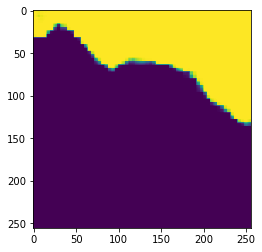

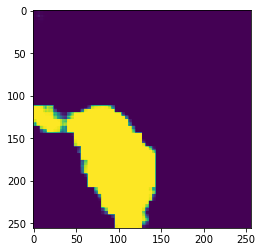

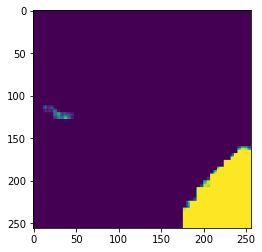

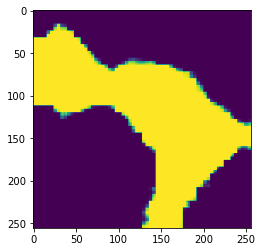

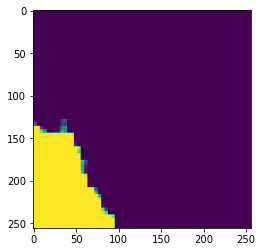

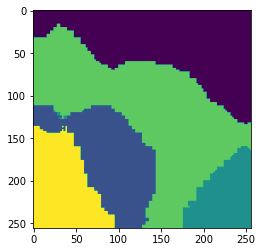

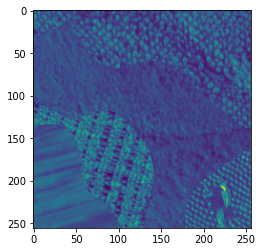

In [19]:
res = model.predict(test)
plt.figure()
plt.imshow(res[0,:,:,0])
plt.figure()
plt.imshow(res[0,:,:,1])
plt.figure()
plt.imshow(res[0,:,:,2])
plt.figure()
plt.imshow(res[0,:,:,3])
plt.figure()
plt.imshow(res[0,:,:,4])
res = np.argmax(res[0,:,:,:],axis = -1)
plt.figure();
plt.imshow(res)
plt.figure();
plt.imshow( plt.imread('data/000/data925.png'),cmap='gray')

In [20]:
score = model.evaluate(test, testlab, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.9781140534083048
Test accuracy: 0.941750705242157


The resulting test accuracy is ~94.2%, which is quite high! While not reaching the accuracy proposed in the paper (due to a smaller training set), we achieve an improvement of +0.5% while only using 2/3 of the data. Deep learning is a hugely adaptive tool. However, it still underperforms in some applications. The use of powerful adaptive pre-processing that are tailored to these problems, which have been studied for decades, is worth exploring. 

### Bibliography
[1] Y.Huang, F.Zhou, J.Gilles, "Empirical curvelet based Fully Convolutional Network for supervised texture image segmentation", Neurocomputing, Vol.349, 31--43, July 2019.